# 目标检测中的坐标回归和车牌识别

全卷积网络，预测车牌16个关键。
和大多数目标检测网络中的BBox定位一样，目标检测中是要预测BBox的x，y，w和h，其实思想是一样的。
这里新能源数据集包含的字符和映射关系：

{'6':0, 'B':1, '7':2, 'D':3, '8':4, '1':5, '2':6, '5':7, 'F':8, '9':9, '4':10, '粤':11, '0':12, '3':13}

In [1]:
import os
import numpy as np
from skimage import io,transform
import matplotlib.pyplot as plt
import torch
import time
from numpy import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

platemap = {'6':0, 'B':1, '7':2, 'D':3, '8':4, '1':5, '2':6, '5':7, 'F':8, '9':9, '4':10, '粤':11, '0':12, '3':13}
invplate = {platemap[k]:k for k in platemap}
batch_size = 32
mean=(104, 117, 123)

## 数据集可视化

In [2]:
invplate

{0: '6',
 1: 'B',
 2: '7',
 3: 'D',
 4: '8',
 5: '1',
 6: '2',
 7: '5',
 8: 'F',
 9: '9',
 10: '4',
 11: '粤',
 12: '0',
 13: '3'}

Image name: 20171016121026584(粤B33533D-绿)sp.jpg
Landmarks shape: (16, 2)
First 4 Landmarks: [[ 24   1]
 [ 64   7]
 [104  15]
 [142  22]]


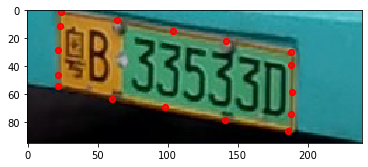

In [3]:
with open("PlateKeyPoint/train.txt","r") as f:
    lines = f.readlines()
    
img_name, landmarks = lines[0].strip().split(" ",1)
# print(landmarks)
landmarks = [int(l) for l in landmarks.split(" ")]
 
# print(landmarks)
landmarks = np.array(landmarks)
# print(landmarks)
landmarks = landmarks.reshape(-1,2)
print('Image name: {}'.format(img_name))
# print(landmarks)
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))
 
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='r',linewidths = 5)
 
plt.figure()
show_landmarks(io.imread(os.path.join('PlateKeyPoint/train/', img_name)),
               landmarks)
plt.show()

## 重写数据加载

In [4]:
def read_label(label_file):
    with open(label_file,"r") as f:
        lines = f.readlines()
    newlines = [line.strip().split(" ",1) for line in lines]
    return newlines
    
class PlateKeyPointDataset(Dataset):
    def __init__(self, label_file, root_dir, transform = None):
        self.keypoint = read_label(label_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoint)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,self.keypoint[idx][0])
#         print(img_name)
        image = io.imread(img_name)
        kp = self.keypoint[idx][1]
        kpnum = [int(p) for p in kp.split(" ")]
        kp = kpnum[:32]
        plate = kpnum[32:]
        kp = np.array(kp)
        kp = kp.astype("float").reshape(-1,2)
        sample = image,kp
        if self.transform:
            sample = self.transform(sample)            
        return sample, plate  
        


## 实现简单的预处理转换

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, kp = sample[0], sample[1]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
#         print("orign shape w: {} h: {} {}".format(w,h,kp))
        
        kp = kp*[self.output_size[1]/w,self.output_size[0]/h]
#         print("after w: {} h: {} {}".format(self.output_size[1],self.output_size[0],kp))

        img = transform.resize(image, (new_h, new_w))
        
        

        return img, kp

In [6]:
class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image


In [7]:
class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), kp

In [8]:
class RandomBrightness(object):
    def __init__(self, delta=2):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, kp

In [9]:
class RandomContrast(object):
    def __init__(self, lower=0.95, upper=1.05):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, kp

In [10]:
class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, kp

In [11]:
class RandomHue(object):
    def __init__(self, delta=0.001):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, kp

In [12]:
class RandomSaturation(object):
    def __init__(self, lower=0.95, upper=1.05):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, sample):
        image, kp = sample[0], sample[1]
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, kp

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors.
        numpy数组到tensor的变化，另外还有维度的变化。
    """
 
    def __call__(self, sample):
        image, kp = sample[0], sample[1]
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        label = torch.from_numpy(kp)
        return image.type(torch.FloatTensor),label.type(torch.FloatTensor),

In [14]:
platekptrain = PlateKeyPointDataset(label_file="./PlateKeyPoint/trainmul.txt",root_dir="./PlateKeyPoint/train",transform=transforms.Compose([Rescale((128,256)),ToTensor()]))
platekpval = PlateKeyPointDataset(label_file="./PlateKeyPoint/valmul.txt",root_dir="./PlateKeyPoint/val",transform=transforms.Compose([Rescale((128,256)),ToTensor()]))

In [15]:
print("训练集大小：%d"%len(platekptrain))
print("验证集大小：%d"%len(platekpval))

训练集大小：693
验证集大小：41


In [16]:
platekp2 = PlateKeyPointDataset(label_file="./PlateKeyPoint/trainmul.txt",root_dir="./PlateKeyPoint/train",transform=transforms.Compose([Rescale((128,256)),
                                                                                                                                         RandomContrast(),RandomSaturation()]))

/home/hwits/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 31908 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hwits/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 31908 missing from current font.
  font.set_text(s, 0, flags=flags)


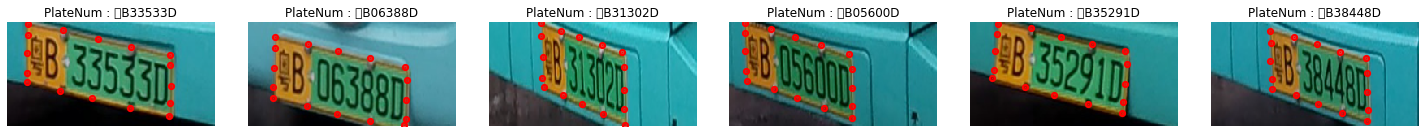

In [17]:
fig = plt.figure(figsize=(20,200))
for i in range(len(platekp2)):
    sample,plate = platekp2[i]
#     print(plate)
#     print(i, sample[0].shape, sample[1].shape )
    loc = sample[1]
#     print(loc)
    ax = plt.subplot(1,6,i+1)
    plt.tight_layout()
    plategt = [invplate[j] for j in plate]
#     print(plategt)
    ax.set_title('PlateNum : {}{}{}{}{}{}{}{}'.format(*plategt))
    ax.axis('off')
#     print(*sample.values())
    show_landmarks(sample[0],sample[1])
    if i == 5:
        plt.show()
        break


In [18]:
loc

array([[ 72.93447293,  10.29885057],
       [102.83760684,  17.65517241],
       [130.55270655,  26.48275862],
       [158.997151  ,  36.7816092 ],
       [191.08831909,  44.13793103],
       [192.54700855,  61.79310345],
       [193.27635328,  85.33333333],
       [194.00569801, 107.40229885],
       [192.54700855, 122.11494253],
       [161.91452991, 111.81609195],
       [132.74074074, 100.04597701],
       [105.02564103,  89.74712644],
       [ 75.85185185,  82.3908046 ],
       [ 75.12250712,  69.14942529],
       [ 72.93447293,  47.08045977],
       [ 73.66381766,  25.01149425]])

lr衰减和warm up，使用xavier初始化CNN权重

In [19]:
loc*np.array([2,4])

array([[145.86894587,  41.1954023 ],
       [205.67521368,  70.62068966],
       [261.10541311, 105.93103448],
       [317.99430199, 147.12643678],
       [382.17663818, 176.55172414],
       [385.09401709, 247.17241379],
       [386.55270655, 341.33333333],
       [388.01139601, 429.6091954 ],
       [385.09401709, 488.45977011],
       [323.82905983, 447.26436782],
       [265.48148148, 400.18390805],
       [210.05128205, 358.98850575],
       [151.7037037 , 329.56321839],
       [150.24501425, 276.59770115],
       [145.86894587, 188.32183908],
       [147.32763533, 100.04597701]])

In [20]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = initial_lr * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def warmup_learning_rate(optimizer,iteration):
    lr_ini = 0.000001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_ini+(initial_lr - lr_ini)*iteration/100

def xavier(param):
    init.xavier_uniform_(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

## DataLoader

In [21]:
trainloader = DataLoader(platekptrain, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(platekpval, batch_size=batch_size, shuffle=False, num_workers=4)

## 模型搭建

### VGG网络 
网络结构搭建，这这里仿照VGG结构，去掉全连接层，并在最后加入1x1卷积用于关键点的回归
![](https://t9.baidu.com/it/u=463051614,2727077879&fm=193)

In [22]:
class VGGRegNet(nn.Module):
    def __init__(self):
        super(VGGRegNet, self).__init__()
        self.conv1_0 = nn.Conv2d(3,16,3,padding=1)
        self.bn1_0 = nn.BatchNorm2d(16)
        self.conv1_1 = nn.Conv2d(16,16,3,padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv2_0 = nn.Conv2d(16,32,3,padding=1)
        self.bn2_0 = nn.BatchNorm2d(32)
        self.conv2_1 = nn.Conv2d(32,32,3,padding=1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv3_0 = nn.Conv2d(32,64,3,padding=1)
        self.bn3_0 = nn.BatchNorm2d(64)
        self.conv3_1 = nn.Conv2d(64,64,3,padding=1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv4_0 = nn.Conv2d(64,128,3,padding=1)
        self.bn4_0 = nn.BatchNorm2d(128)
        self.conv4_1 = nn.Conv2d(128,128,3,padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.conv5_0 = nn.Conv2d(128,256,3,padding=1)
        self.bn5_0 = nn.BatchNorm2d(256)
        self.conv5_1 = nn.Conv2d(256,256,3,padding=1)
        self.bn5_1 = nn.BatchNorm2d(256)
        self.conv6_0 = nn.Conv2d(256,512,3,padding=1)
        self.bn6_0 = nn.BatchNorm2d(512)
        self.conv6_1 = nn.Conv2d(512,512,3,padding=1)
        self.bn6_1 = nn.BatchNorm2d(512)
        self.loc = nn.Conv2d(512,16,2,stride = 2)

        
        
        self.numconv = nn.Conv2d(256,256,3,padding=1)
        self.bn_num = nn.BatchNorm2d(256)
        
        self.fc = nn.Linear(256*2*16,512)
        self.number1 = nn.Linear(512,14)
        self.number2 = nn.Linear(512,14)
        self.number3 = nn.Linear(512,14)
        self.number4 = nn.Linear(512,14)
        self.number5 = nn.Linear(512,14)
        self.number6 = nn.Linear(512,14)
        self.number7 = nn.Linear(512,14)
        self.number8 = nn.Linear(512,14)
                     
    def forward(self, x):                             #3x128x256
        x = F.relu(self.bn1_0(self.conv1_0(x)))
        x = F.max_pool2d(F.relu(self.bn1_1(self.conv1_1(x))),2)     #16x64x128
        x = F.relu(self.bn2_0(self.conv2_0(x)))
        x = F.max_pool2d(F.relu(self.bn2_1(self.conv2_1(x))),2)     #32x32x64
        x = F.relu(self.bn3_0(self.conv3_0(x)))
        x = F.max_pool2d(F.relu(self.bn3_1(self.conv3_1(x))),2)   #64x16x32
        x = F.relu(self.bn4_0(self.conv4_0(x)))
        x = F.max_pool2d(F.relu(self.bn4_1(self.conv4_1(x))),2)     #128x8x16
        x = F.relu(self.bn5_0(self.conv5_0(x)))                    #256x8x16
        x1 = F.relu(self.bn_num(self.numconv(x)))                    #256x8x16
        x1 = F.max_pool2d(x1,(1,4),(1,4))                           #256x2x16
#         print(x1.size())
        x1 = x1.view(-1,self.num_flat_features(x1))
#         print(x1.size())
        y = F.relu(self.fc(x1))
        y1 = self.number1(y)
        y2 = self.number2(y)   
        y3 = self.number3(y)   
        y4 = self.number4(y)   
        y5 = self.number5(y)   
        y6 = self.number6(y)   
        y7 = self.number7(y)  
        y8 = self.number8(y)   # 14预测
        x = F.max_pool2d(F.relu(self.bn5_1(self.conv5_1(x))),2)     #256x4x8
        x = F.relu(self.bn6_0(self.conv6_0(x)))                     #512x4x8
        x = F.max_pool2d(F.relu(self.bn6_1(self.conv6_1(x))),2)     #512x2x4
        x = self.loc(x)                                 #1*2*16
#         x = x.view()
        return x, y1, y2, y3, y4, y5, y6, y7, y8    
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for i in size:
            num_features *= i
        return num_features

### 残差网络

仿照Resnet结构搭模型

In [23]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积

In [24]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=14):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.locpool = nn.MaxPool2d(kernel_size=4, stride=4)
        self.loc = nn.Conv2d(512,16,1)
        
        self.platepool = nn.MaxPool2d(kernel_size=4, stride=1)
        
        
        self.linear1 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear2 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear3 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear4 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear5 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear6 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear7 = nn.Linear(512*5*block.expansion, num_classes)
        self.linear8 = nn.Linear(512*5*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))        #64x64x128
        out = self.maxpool(out)                     #64x32x64
        out = self.layer1(out)                      #64x32x64
        out = self.layer2(out)                      #128x16x32   
        out = self.layer3(out)                      #256x8x16
        out = self.layer4(out)                      #512x4x8
        loc = self.locpool(out)                # 512x1x2
        loc = self.loc(loc)
        out = self.platepool(out)                   #512x1x5
        out = out.view(out.size(0), -1)
        out1 = self.linear1(out)
        out2 = self.linear2(out)
        out3 = self.linear3(out)
        out4 = self.linear4(out)
        out5 = self.linear5(out)
        out6 = self.linear6(out)
        out7 = self.linear7(out)
        out8 = self.linear8(out)
        return loc,out1,out2,out3,out4,out5,out6,out7,out8

In [25]:
def ResNetPlate():
    return ResNet(BasicBlock, [2,2,2,2])

In [26]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [27]:
net= VGGRegNet()
net.apply(weights_init)
print(net)

VGGRegNet(
  (conv1_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [28]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('log') #建立一个保存数据用的东西
# dummy_input = torch.rand(1, 3, 128, 256)  # 假设输入20张1*28*28的图片
# with SummaryWriter(comment='VGGRegNet') as w:
#     w.add_graph(net, (dummy_input,))

In [29]:
# from torchviz import make_dot
# x = torch.randn(1, 3, 128, 256)
# vis_graph = make_dot(net(x),params=dict(net.named_parameters()))
# vis_graph.view()

In [30]:
criterion = nn.SmoothL1Loss()
criterion2 = nn.CrossEntropyLoss()
initial_lr = 0.001
optimizer = optim.AdamW(net.parameters(), lr = initial_lr)
# optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


VGGRegNet(
  (conv1_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## 网络训练

In [32]:
lr_decay = [2500,4600,5200]
step_index = 0
tlall = []
tllall = []
tplall = []
vlall = []
vllall = []
vplall = []
for iteration in range(6000):
    running_loss= 0
    running_loc_loss = 0
    running_plate_loss = 0
    val_loss = 0
    val_loc_loss = 0
    val_plate_loss = 0
    
    start = time.time()
    batch_iterator = iter(trainloader)
    (images, labels), plate = next(batch_iterator)
#     print(images)
    images = images.to(device)
    labels = labels.to(device)
    val_iter = iter(valloader)
    (valimg,vallabels),vplate = next(val_iter)
    valimg = valimg.to(device)
    vallabels = vallabels.to(device)

    optimizer.zero_grad()
    outputs,p1,p2,p3,p4,p5,p6,p7,p8= net(images)
#     print(outputs.size())
#     print(labels.size())
    outputs = outputs.squeeze(2)
#     print(outputs.size())
    loss0 = criterion(outputs,labels)
    ############# 车牌识别损失函数#############
#     plate1 = plate[0].unsqueeze(1)
#     plate2 = plate[1].unsqueeze(1)
#     plate3 = plate[2].unsqueeze(1)
#     plate4 = plate[3].unsqueeze(1)
#     plate5 = plate[4].unsqueeze(1)
#     plate6 = plate[5].unsqueeze(1)
#     plate7 = plate[6].unsqueeze(1)
#     plate8 = plate[7].unsqueeze(1)
    plate1 = plate[0]
    plate2 = plate[1]
    plate3 = plate[2]
    plate4 = plate[3]
    plate5 = plate[4]
    plate6 = plate[5]
    plate7 = plate[6]
    plate8 = plate[7]
#     plate1 = torch.zeros(batch_size, 14).scatter_(1, plate1, 1)
#     plate2 = torch.zeros(batch_size, 14).scatter_(1, plate2, 1)
#     plate3 = torch.zeros(batch_size, 14).scatter_(1, plate3, 1)
#     plate4 = torch.zeros(batch_size, 14).scatter_(1, plate4, 1)
#     plate5 = torch.zeros(batch_size, 14).scatter_(1, plate5, 1)
#     plate6 = torch.zeros(batch_size, 14).scatter_(1, plate6, 1)
#     plate7 = torch.zeros(batch_size, 14).scatter_(1, plate7, 1)
#     plate8 = torch.zeros(batch_size, 14).scatter_(1, plate8, 1)
#     print(plate1)
#     plate1 = plate1.long()
#     print(plate1.type())    
#     print("target:",plate1.size())
#     print("predict:",p1.size())
    loss1 = criterion2(p1,plate1.to(device))
    loss2 = criterion2(p2,plate2.to(device))
    loss3 = criterion2(p3,plate3.to(device))
    loss4 = criterion2(p4,plate4.to(device))
    loss5 = criterion2(p5,plate5.to(device))
    loss6 = criterion2(p6,plate6.to(device))
    loss7 = criterion2(p7,plate7.to(device))
    loss8 = criterion2(p8,plate8.to(device))
    locloss = loss0
    plateloss = loss1+loss2+loss3+loss4+loss5+loss6+loss7+loss8
    loss = locloss + plateloss
    
    
    
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    running_loc_loss += locloss.item()
    running_plate_loss += plateloss.item()
    
    val_out,vp1,vp2,vp3,vp4,vp5,vp6,vp7,vp8 = net(valimg)
    val_out = val_out.squeeze(2)
    vallocloss = criterion(val_out,vallabels)
#     print(len(vplate))
#     print(vplate)
    
    vplate1 = vplate[0]
    vplate2 = vplate[1]
    vplate3 = vplate[2]
    vplate4 = vplate[3]
    vplate5 = vplate[4]
    vplate6 = vplate[5]
    vplate7 = vplate[6]
    vplate8 = vplate[7]
#     vplate1 = torch.zeros(batch_size, 14).scatter_(1, vplate1, 1)
#     vplate2 = torch.zeros(batch_size, 14).scatter_(1, vplate2, 1)
#     vplate3 = torch.zeros(batch_size, 14).scatter_(1, vplate3, 1)
#     vplate4 = torch.zeros(batch_size, 14).scatter_(1, vplate4, 1)
#     vplate5 = torch.zeros(batch_size, 14).scatter_(1, vplate5, 1)
#     vplate6 = torch.zeros(batch_size, 14).scatter_(1, vplate6, 1)
#     vplate7 = torch.zeros(batch_size, 14).scatter_(1, vplate7, 1)
#     vplate8 = torch.zeros(batch_size, 14).scatter_(1, vplate8, 1)

    
    vloss1 = criterion2(vp1,vplate1.to(device))
    vloss2 = criterion2(vp2,vplate2.to(device))
    vloss3 = criterion2(vp3,vplate3.to(device))
    vloss4 = criterion2(vp4,vplate4.to(device))
    vloss5 = criterion2(vp5,vplate5.to(device))
    vloss6 = criterion2(vp6,vplate6.to(device))
    vloss7 = criterion2(vp7,vplate7.to(device))
    vloss8 = criterion2(vp8,vplate8.to(device))
    vploss = vloss1+vloss2+vloss3+vloss4+vloss5+vloss6+vloss7+vloss8
    valloss = vallocloss+vploss
    val_loss += valloss.item()
    val_loc_loss += vallocloss.item()
    val_plate_loss += vploss.item()
    
    
    if iteration <=100:
        warmup_learning_rate(optimizer,iteration)
    if iteration in lr_decay:
        step_index += 1
        adjust_learning_rate(optimizer, 0.2, step_index)
    for param in optimizer.param_groups:
        if 'lr' in param.keys():  
            if iteration % 10 == 9:
                tlall.append(running_loss / 10)
                vlall.append(val_loss / 10)
                tllall.append(running_loc_loss / 10)
                tplall.append(running_plate_loss / 10)
                vllall.append(val_loc_loss / 10)
                vplall.append(val_plate_loss / 10)
                print("Iter %d  || LR %f || TrainLoss %.4f || TrainLocLoss %.4f || TrainClsLoss %.4f || ValLoss %.4f || ValLocLoss %.4f || ValClsLoss %.4f || Time: %f"%(iteration+1,param['lr'],running_loss / 10,running_loc_loss /10 ,running_plate_loss /10,val_loss / 10,val_loc_loss/10,val_plate_loss /10,time.time()-start))
    running_loss = 0
#     running_loss= 0
    running_loc_loss = 0
    running_plate_loss = 0
    val_loss = 0
    val_loc_loss = 0
    val_plate_loss = 0
            
print("Finish Training...")
            

Iter 10  || LR 0.000091 || TrainLoss 9.9500 || TrainLocLoss 8.2915 || TrainClsLoss 1.6585 || ValLoss 9.0820 || ValLocLoss 7.6879 || ValClsLoss 1.3941 || Time: 0.634009
Iter 20  || LR 0.000191 || TrainLoss 8.5069 || TrainLocLoss 7.2956 || TrainClsLoss 1.2113 || ValLoss 8.4728 || ValLocLoss 7.0954 || ValClsLoss 1.3774 || Time: 0.612329
Iter 30  || LR 0.000291 || TrainLoss 7.8106 || TrainLocLoss 6.6802 || TrainClsLoss 1.1305 || ValLoss 7.5611 || ValLocLoss 6.3116 || ValClsLoss 1.2495 || Time: 0.650732
Iter 40  || LR 0.000391 || TrainLoss 6.6331 || TrainLocLoss 5.6365 || TrainClsLoss 0.9966 || ValLoss 6.4677 || ValLocLoss 5.3259 || ValClsLoss 1.1418 || Time: 0.624529
Iter 50  || LR 0.000491 || TrainLoss 5.9550 || TrainLocLoss 4.9654 || TrainClsLoss 0.9896 || ValLoss 5.3332 || ValLocLoss 4.2250 || ValClsLoss 1.1081 || Time: 0.603461
Iter 60  || LR 0.000590 || TrainLoss 4.4107 || TrainLocLoss 3.4594 || TrainClsLoss 0.9513 || ValLoss 4.3437 || ValLocLoss 3.1767 || ValClsLoss 1.1670 || Time: 0

Iter 500  || LR 0.001000 || TrainLoss 0.1927 || TrainLocLoss 0.1885 || TrainClsLoss 0.0043 || ValLoss 0.4860 || ValLocLoss 0.1999 || ValClsLoss 0.2860 || Time: 0.639672
Iter 510  || LR 0.001000 || TrainLoss 0.1110 || TrainLocLoss 0.1068 || TrainClsLoss 0.0043 || ValLoss 0.4343 || ValLocLoss 0.1630 || ValClsLoss 0.2713 || Time: 0.717058
Iter 520  || LR 0.001000 || TrainLoss 0.1866 || TrainLocLoss 0.1831 || TrainClsLoss 0.0035 || ValLoss 0.5151 || ValLocLoss 0.1935 || ValClsLoss 0.3216 || Time: 0.627607
Iter 530  || LR 0.001000 || TrainLoss 0.1246 || TrainLocLoss 0.1233 || TrainClsLoss 0.0012 || ValLoss 0.4975 || ValLocLoss 0.1660 || ValClsLoss 0.3315 || Time: 0.640833
Iter 540  || LR 0.001000 || TrainLoss 0.1801 || TrainLocLoss 0.1778 || TrainClsLoss 0.0023 || ValLoss 0.4652 || ValLocLoss 0.2282 || ValClsLoss 0.2370 || Time: 0.636367
Iter 550  || LR 0.001000 || TrainLoss 0.1228 || TrainLocLoss 0.1207 || TrainClsLoss 0.0021 || ValLoss 0.5297 || ValLocLoss 0.2334 || ValClsLoss 0.2964 || T

Iter 990  || LR 0.001000 || TrainLoss 0.1354 || TrainLocLoss 0.1347 || TrainClsLoss 0.0007 || ValLoss 0.5348 || ValLocLoss 0.2247 || ValClsLoss 0.3101 || Time: 0.672359
Iter 1000  || LR 0.001000 || TrainLoss 0.0884 || TrainLocLoss 0.0877 || TrainClsLoss 0.0007 || ValLoss 0.5315 || ValLocLoss 0.2256 || ValClsLoss 0.3059 || Time: 0.648974
Iter 1010  || LR 0.001000 || TrainLoss 0.0983 || TrainLocLoss 0.0979 || TrainClsLoss 0.0005 || ValLoss 0.4370 || ValLocLoss 0.1428 || ValClsLoss 0.2942 || Time: 0.620754
Iter 1020  || LR 0.001000 || TrainLoss 0.1303 || TrainLocLoss 0.1297 || TrainClsLoss 0.0006 || ValLoss 0.4325 || ValLocLoss 0.1682 || ValClsLoss 0.2643 || Time: 0.656016
Iter 1030  || LR 0.001000 || TrainLoss 0.1233 || TrainLocLoss 0.1229 || TrainClsLoss 0.0005 || ValLoss 0.4622 || ValLocLoss 0.1721 || ValClsLoss 0.2901 || Time: 0.618349
Iter 1040  || LR 0.001000 || TrainLoss 0.0851 || TrainLocLoss 0.0846 || TrainClsLoss 0.0006 || ValLoss 0.4249 || ValLocLoss 0.1526 || ValClsLoss 0.2723

Iter 1480  || LR 0.001000 || TrainLoss 0.0930 || TrainLocLoss 0.0927 || TrainClsLoss 0.0003 || ValLoss 0.4569 || ValLocLoss 0.1703 || ValClsLoss 0.2865 || Time: 0.604160
Iter 1490  || LR 0.001000 || TrainLoss 0.0875 || TrainLocLoss 0.0873 || TrainClsLoss 0.0002 || ValLoss 0.4604 || ValLocLoss 0.1780 || ValClsLoss 0.2824 || Time: 0.611133
Iter 1500  || LR 0.001000 || TrainLoss 0.0692 || TrainLocLoss 0.0688 || TrainClsLoss 0.0004 || ValLoss 0.4769 || ValLocLoss 0.2055 || ValClsLoss 0.2714 || Time: 0.639168
Iter 1510  || LR 0.001000 || TrainLoss 0.0627 || TrainLocLoss 0.0625 || TrainClsLoss 0.0002 || ValLoss 0.4218 || ValLocLoss 0.1472 || ValClsLoss 0.2747 || Time: 0.713981
Iter 1520  || LR 0.001000 || TrainLoss 0.0705 || TrainLocLoss 0.0702 || TrainClsLoss 0.0003 || ValLoss 0.4396 || ValLocLoss 0.1545 || ValClsLoss 0.2851 || Time: 0.712470
Iter 1530  || LR 0.001000 || TrainLoss 0.1023 || TrainLocLoss 0.1020 || TrainClsLoss 0.0003 || ValLoss 0.4367 || ValLocLoss 0.1501 || ValClsLoss 0.286

Iter 1970  || LR 0.001000 || TrainLoss 0.1614 || TrainLocLoss 0.0894 || TrainClsLoss 0.0721 || ValLoss 0.5967 || ValLocLoss 0.2137 || ValClsLoss 0.3830 || Time: 0.628677
Iter 1980  || LR 0.001000 || TrainLoss 0.1160 || TrainLocLoss 0.0953 || TrainClsLoss 0.0206 || ValLoss 0.4853 || ValLocLoss 0.1904 || ValClsLoss 0.2949 || Time: 0.621610
Iter 1990  || LR 0.001000 || TrainLoss 0.1901 || TrainLocLoss 0.1227 || TrainClsLoss 0.0674 || ValLoss 0.5860 || ValLocLoss 0.2034 || ValClsLoss 0.3826 || Time: 0.652144
Iter 2000  || LR 0.001000 || TrainLoss 0.1676 || TrainLocLoss 0.1081 || TrainClsLoss 0.0595 || ValLoss 0.5328 || ValLocLoss 0.1888 || ValClsLoss 0.3440 || Time: 0.623026
Iter 2010  || LR 0.001000 || TrainLoss 0.1241 || TrainLocLoss 0.0968 || TrainClsLoss 0.0273 || ValLoss 0.4682 || ValLocLoss 0.1560 || ValClsLoss 0.3122 || Time: 0.625157
Iter 2020  || LR 0.001000 || TrainLoss 0.0834 || TrainLocLoss 0.0643 || TrainClsLoss 0.0190 || ValLoss 0.5207 || ValLocLoss 0.1705 || ValClsLoss 0.350

Iter 2460  || LR 0.001000 || TrainLoss 0.0676 || TrainLocLoss 0.0675 || TrainClsLoss 0.0001 || ValLoss 0.4037 || ValLocLoss 0.1808 || ValClsLoss 0.2229 || Time: 0.653899
Iter 2470  || LR 0.001000 || TrainLoss 0.0841 || TrainLocLoss 0.0839 || TrainClsLoss 0.0001 || ValLoss 0.3780 || ValLocLoss 0.1677 || ValClsLoss 0.2104 || Time: 0.633293
Iter 2480  || LR 0.001000 || TrainLoss 0.0564 || TrainLocLoss 0.0564 || TrainClsLoss 0.0001 || ValLoss 0.3911 || ValLocLoss 0.1620 || ValClsLoss 0.2290 || Time: 0.643939
Iter 2490  || LR 0.001000 || TrainLoss 0.0693 || TrainLocLoss 0.0693 || TrainClsLoss 0.0001 || ValLoss 0.3979 || ValLocLoss 0.1622 || ValClsLoss 0.2357 || Time: 0.623346
Iter 2500  || LR 0.001000 || TrainLoss 0.0801 || TrainLocLoss 0.0800 || TrainClsLoss 0.0001 || ValLoss 0.4011 || ValLocLoss 0.1583 || ValClsLoss 0.2427 || Time: 0.617964
Iter 2510  || LR 0.000200 || TrainLoss 0.0581 || TrainLocLoss 0.0580 || TrainClsLoss 0.0001 || ValLoss 0.4101 || ValLocLoss 0.1721 || ValClsLoss 0.238

Iter 2950  || LR 0.000200 || TrainLoss 0.0379 || TrainLocLoss 0.0378 || TrainClsLoss 0.0001 || ValLoss 0.3789 || ValLocLoss 0.1481 || ValClsLoss 0.2308 || Time: 0.666751
Iter 2960  || LR 0.000200 || TrainLoss 0.0373 || TrainLocLoss 0.0373 || TrainClsLoss 0.0000 || ValLoss 0.3782 || ValLocLoss 0.1473 || ValClsLoss 0.2309 || Time: 0.666723
Iter 2970  || LR 0.000200 || TrainLoss 0.0341 || TrainLocLoss 0.0340 || TrainClsLoss 0.0001 || ValLoss 0.3727 || ValLocLoss 0.1401 || ValClsLoss 0.2327 || Time: 0.631155
Iter 2980  || LR 0.000200 || TrainLoss 0.0357 || TrainLocLoss 0.0357 || TrainClsLoss 0.0000 || ValLoss 0.3639 || ValLocLoss 0.1291 || ValClsLoss 0.2348 || Time: 0.672891
Iter 2990  || LR 0.000200 || TrainLoss 0.0355 || TrainLocLoss 0.0355 || TrainClsLoss 0.0001 || ValLoss 0.3709 || ValLocLoss 0.1334 || ValClsLoss 0.2375 || Time: 0.635437
Iter 3000  || LR 0.000200 || TrainLoss 0.0350 || TrainLocLoss 0.0349 || TrainClsLoss 0.0001 || ValLoss 0.3740 || ValLocLoss 0.1380 || ValClsLoss 0.235

Iter 3440  || LR 0.000200 || TrainLoss 0.0355 || TrainLocLoss 0.0355 || TrainClsLoss 0.0000 || ValLoss 0.3852 || ValLocLoss 0.1521 || ValClsLoss 0.2332 || Time: 0.630522
Iter 3450  || LR 0.000200 || TrainLoss 0.0306 || TrainLocLoss 0.0306 || TrainClsLoss 0.0001 || ValLoss 0.3808 || ValLocLoss 0.1474 || ValClsLoss 0.2334 || Time: 0.616809
Iter 3460  || LR 0.000200 || TrainLoss 0.0292 || TrainLocLoss 0.0291 || TrainClsLoss 0.0000 || ValLoss 0.3835 || ValLocLoss 0.1518 || ValClsLoss 0.2316 || Time: 0.645748
Iter 3470  || LR 0.000200 || TrainLoss 0.0346 || TrainLocLoss 0.0345 || TrainClsLoss 0.0000 || ValLoss 0.3866 || ValLocLoss 0.1565 || ValClsLoss 0.2301 || Time: 0.629274
Iter 3480  || LR 0.000200 || TrainLoss 0.0354 || TrainLocLoss 0.0354 || TrainClsLoss 0.0000 || ValLoss 0.3749 || ValLocLoss 0.1476 || ValClsLoss 0.2274 || Time: 0.625843
Iter 3490  || LR 0.000200 || TrainLoss 0.0301 || TrainLocLoss 0.0301 || TrainClsLoss 0.0000 || ValLoss 0.3702 || ValLocLoss 0.1408 || ValClsLoss 0.229

Iter 3930  || LR 0.000200 || TrainLoss 0.0340 || TrainLocLoss 0.0340 || TrainClsLoss 0.0001 || ValLoss 0.3656 || ValLocLoss 0.1391 || ValClsLoss 0.2265 || Time: 0.631952
Iter 3940  || LR 0.000200 || TrainLoss 0.0309 || TrainLocLoss 0.0308 || TrainClsLoss 0.0001 || ValLoss 0.3623 || ValLocLoss 0.1386 || ValClsLoss 0.2237 || Time: 0.642391
Iter 3950  || LR 0.000200 || TrainLoss 0.0282 || TrainLocLoss 0.0282 || TrainClsLoss 0.0000 || ValLoss 0.3732 || ValLocLoss 0.1513 || ValClsLoss 0.2219 || Time: 0.645260
Iter 3960  || LR 0.000200 || TrainLoss 0.0313 || TrainLocLoss 0.0312 || TrainClsLoss 0.0000 || ValLoss 0.3868 || ValLocLoss 0.1600 || ValClsLoss 0.2268 || Time: 0.661818
Iter 3970  || LR 0.000200 || TrainLoss 0.0315 || TrainLocLoss 0.0315 || TrainClsLoss 0.0000 || ValLoss 0.3857 || ValLocLoss 0.1533 || ValClsLoss 0.2324 || Time: 0.644702
Iter 3980  || LR 0.000200 || TrainLoss 0.0306 || TrainLocLoss 0.0306 || TrainClsLoss 0.0000 || ValLoss 0.3910 || ValLocLoss 0.1577 || ValClsLoss 0.233

Iter 4420  || LR 0.000200 || TrainLoss 0.0260 || TrainLocLoss 0.0259 || TrainClsLoss 0.0001 || ValLoss 0.3745 || ValLocLoss 0.1371 || ValClsLoss 0.2374 || Time: 0.678451
Iter 4430  || LR 0.000200 || TrainLoss 0.0252 || TrainLocLoss 0.0252 || TrainClsLoss 0.0000 || ValLoss 0.3744 || ValLocLoss 0.1352 || ValClsLoss 0.2392 || Time: 0.698068
Iter 4440  || LR 0.000200 || TrainLoss 0.0258 || TrainLocLoss 0.0257 || TrainClsLoss 0.0000 || ValLoss 0.3723 || ValLocLoss 0.1353 || ValClsLoss 0.2370 || Time: 0.647734
Iter 4450  || LR 0.000200 || TrainLoss 0.0254 || TrainLocLoss 0.0253 || TrainClsLoss 0.0000 || ValLoss 0.3780 || ValLocLoss 0.1418 || ValClsLoss 0.2362 || Time: 0.624359
Iter 4460  || LR 0.000200 || TrainLoss 0.0365 || TrainLocLoss 0.0364 || TrainClsLoss 0.0000 || ValLoss 0.3755 || ValLocLoss 0.1375 || ValClsLoss 0.2381 || Time: 0.653349
Iter 4470  || LR 0.000200 || TrainLoss 0.0257 || TrainLocLoss 0.0257 || TrainClsLoss 0.0000 || ValLoss 0.3843 || ValLocLoss 0.1443 || ValClsLoss 0.239

Iter 4910  || LR 0.000040 || TrainLoss 0.0246 || TrainLocLoss 0.0246 || TrainClsLoss 0.0000 || ValLoss 0.3892 || ValLocLoss 0.1480 || ValClsLoss 0.2413 || Time: 0.627857
Iter 4920  || LR 0.000040 || TrainLoss 0.0216 || TrainLocLoss 0.0216 || TrainClsLoss 0.0000 || ValLoss 0.3826 || ValLocLoss 0.1424 || ValClsLoss 0.2402 || Time: 0.611749
Iter 4930  || LR 0.000040 || TrainLoss 0.0162 || TrainLocLoss 0.0162 || TrainClsLoss 0.0000 || ValLoss 0.3863 || ValLocLoss 0.1447 || ValClsLoss 0.2416 || Time: 0.630678
Iter 4940  || LR 0.000040 || TrainLoss 0.0200 || TrainLocLoss 0.0200 || TrainClsLoss 0.0000 || ValLoss 0.3866 || ValLocLoss 0.1448 || ValClsLoss 0.2418 || Time: 0.615414
Iter 4950  || LR 0.000040 || TrainLoss 0.0178 || TrainLocLoss 0.0177 || TrainClsLoss 0.0000 || ValLoss 0.3870 || ValLocLoss 0.1454 || ValClsLoss 0.2417 || Time: 0.630961
Iter 4960  || LR 0.000040 || TrainLoss 0.0165 || TrainLocLoss 0.0165 || TrainClsLoss 0.0000 || ValLoss 0.3857 || ValLocLoss 0.1443 || ValClsLoss 0.241

Iter 5400  || LR 0.000008 || TrainLoss 0.0185 || TrainLocLoss 0.0185 || TrainClsLoss 0.0001 || ValLoss 0.3843 || ValLocLoss 0.1445 || ValClsLoss 0.2398 || Time: 0.641630
Iter 5410  || LR 0.000008 || TrainLoss 0.0168 || TrainLocLoss 0.0168 || TrainClsLoss 0.0000 || ValLoss 0.3833 || ValLocLoss 0.1439 || ValClsLoss 0.2394 || Time: 0.661529
Iter 5420  || LR 0.000008 || TrainLoss 0.0183 || TrainLocLoss 0.0183 || TrainClsLoss 0.0000 || ValLoss 0.3822 || ValLocLoss 0.1431 || ValClsLoss 0.2390 || Time: 0.639913
Iter 5430  || LR 0.000008 || TrainLoss 0.0187 || TrainLocLoss 0.0187 || TrainClsLoss 0.0000 || ValLoss 0.3820 || ValLocLoss 0.1431 || ValClsLoss 0.2388 || Time: 0.639961
Iter 5440  || LR 0.000008 || TrainLoss 0.0203 || TrainLocLoss 0.0203 || TrainClsLoss 0.0000 || ValLoss 0.3835 || ValLocLoss 0.1448 || ValClsLoss 0.2387 || Time: 0.674360
Iter 5450  || LR 0.000008 || TrainLoss 0.0189 || TrainLocLoss 0.0189 || TrainClsLoss 0.0000 || ValLoss 0.3826 || ValLocLoss 0.1441 || ValClsLoss 0.238

Iter 5890  || LR 0.000008 || TrainLoss 0.0179 || TrainLocLoss 0.0178 || TrainClsLoss 0.0000 || ValLoss 0.3845 || ValLocLoss 0.1446 || ValClsLoss 0.2399 || Time: 0.626534
Iter 5900  || LR 0.000008 || TrainLoss 0.0174 || TrainLocLoss 0.0174 || TrainClsLoss 0.0000 || ValLoss 0.3838 || ValLocLoss 0.1440 || ValClsLoss 0.2398 || Time: 0.637624
Iter 5910  || LR 0.000008 || TrainLoss 0.0174 || TrainLocLoss 0.0174 || TrainClsLoss 0.0000 || ValLoss 0.3831 || ValLocLoss 0.1433 || ValClsLoss 0.2398 || Time: 0.677919
Iter 5920  || LR 0.000008 || TrainLoss 0.0216 || TrainLocLoss 0.0216 || TrainClsLoss 0.0000 || ValLoss 0.3834 || ValLocLoss 0.1437 || ValClsLoss 0.2397 || Time: 0.616822
Iter 5930  || LR 0.000008 || TrainLoss 0.0172 || TrainLocLoss 0.0171 || TrainClsLoss 0.0000 || ValLoss 0.3835 || ValLocLoss 0.1441 || ValClsLoss 0.2394 || Time: 0.654237
Iter 5940  || LR 0.000008 || TrainLoss 0.0203 || TrainLocLoss 0.0202 || TrainClsLoss 0.0000 || ValLoss 0.3845 || ValLocLoss 0.1451 || ValClsLoss 0.239

In [33]:
torch.save(net.state_dict(), "vggregnet-base-weights3.pth")
torch.save(net, "vggregnet-base3.pth")

/home/hwits/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VGGRegNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/hwits/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/hwits/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/hwits/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

In [34]:
# net.load_state_dict(torch.load("vggregnet-base-weights.pth"))

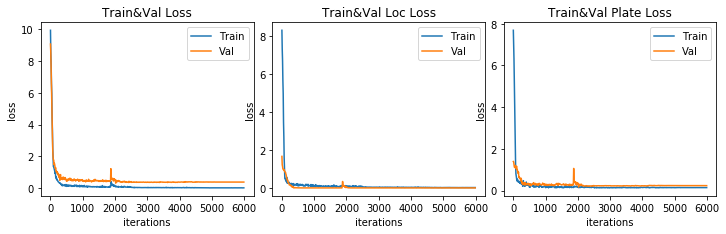

In [35]:
fig = plt.figure(figsize=(10,3))
x = list(range(len(tlall)))
x = [10*s for s in x]
ax = plt.subplot(1,3,1)
plt.tight_layout()
ax.set_title('Train&Val Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
1
plt.plot(x,tlall)
plt.plot(x,vlall)
plt.legend(["Train","Val"])
ax = plt.subplot(1,3,2)
plt.plot(x,tllall)
plt.plot(x,tplall)
ax.set_title('Train&Val Loc Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(["Train","Val"])
ax = plt.subplot(1,3,3)
plt.plot(x,vllall)
plt.plot(x,vplall)
ax.set_title('Train&Val Plate Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(["Train","Val"])
 
plt.show()


## 单张图片测试

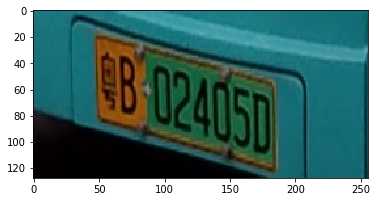

In [36]:
img1 = io.imread("./PlateKeyPoint/val/20171110083856993_粤B02405D_sp.jpg")

img1 = transform.resize(img1, (128, 256))
plt.imshow(img1)

In [37]:
img =img1 
img = img.transpose((2, 0, 1))

In [38]:
img = np.array(img)
img = torch.from_numpy(img)

img = img.unsqueeze(0)
img = img.type(torch.FloatTensor)
img = img.cuda()

In [39]:
predict = net(img)

In [40]:
keyp, pn1,pn2,pn3,pn4,pn5,pn6,pn7,pn8 = predict

In [41]:
pn1=pn1.squeeze(0)

In [42]:
plate1 = torch.argmax(pn1).item()
plate2 = torch.argmax(pn2).item()
plate3 = torch.argmax(pn3).item()
plate4 = torch.argmax(pn4).item()
plate5 = torch.argmax(pn5).item()
plate6 = torch.argmax(pn6).item()
plate7 = torch.argmax(pn7).item()
plate8 = torch.argmax(pn8).item()
plate = "{}{}{}{}{}{}{}{}".format(invplate[plate1],invplate[plate2],invplate[plate3],invplate[plate4],
                                  invplate[plate5],invplate[plate6],invplate[plate7],invplate[plate8])

In [43]:
plate

'粤B02405D'

In [44]:
[plate1,plate2,plate3,plate4,plate5,plate6,plate7,plate8]

[11, 1, 12, 6, 10, 12, 7, 3]

In [45]:
keyp = keyp.squeeze(2)
keyp = keyp.squeeze(0)

In [46]:
pkp = keyp.cpu().detach().numpy()

In [47]:
pkp = pkp.reshape(-1,2)

predict plate number: 粤B02405D


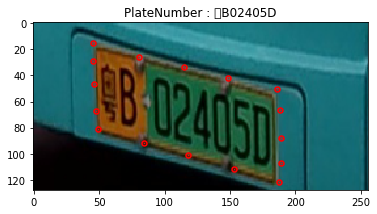

In [48]:
print("predict plate number:",plate)
plt.imshow(img1)
plt.title("PlateNumber : {}".format(plate))
plt.scatter(pkp[:, 0], pkp[:, 1], s=10, marker='.', c='r',linewidths = 5) 

## 验证集批量测试

0 torch.Size([3, 128, 256]) torch.Size([16, 2])
torch.Size([3, 128, 256])
1 torch.Size([3, 128, 256]) torch.Size([16, 2])
torch.Size([3, 128, 256])
2 torch.Size([3, 128, 256]) torch.Size([16, 2])
torch.Size([3, 128, 256])
3 torch.Size([3, 128, 256]) torch.Size([16, 2])
torch.Size([3, 128, 256])
4 torch.Size([3, 128, 256]) torch.Size([16, 2])
torch.Size([3, 128, 256])


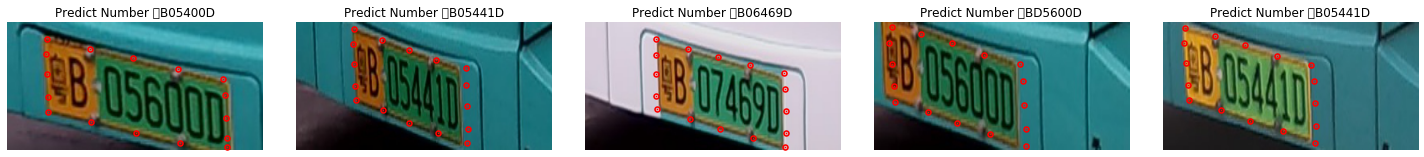

In [49]:
fig = plt.figure(figsize=(20,100))
for i in range(len(platekpval)):
    sample,plate = platekpval[i]
    print(i, sample[0].shape, sample[1].shape )
    predict,pn1,pn2,pn3,pn4,pn5,pn6,pn7,pn8 = net(sample[0].unsqueeze(0).cuda())
    predict = predict.squeeze(2)
    predict = predict.squeeze(0)
    pkp = predict.cpu().detach().numpy()
    plate1 = torch.argmax(pn1).item()
    plate2 = torch.argmax(pn2).item()
    plate3 = torch.argmax(pn3).item()
    plate4 = torch.argmax(pn4).item()
    plate5 = torch.argmax(pn5).item()
    plate6 = torch.argmax(pn6).item()
    plate7 = torch.argmax(pn7).item()
    plate8 = torch.argmax(pn8).item()
    plate = "{}{}{}{}{}{}{}{}".format(invplate[plate1],invplate[plate2],invplate[plate3],invplate[plate4],
                                      invplate[plate5],invplate[plate6],invplate[plate7],invplate[plate8])
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Predict Number {}'.format(plate))
    ax.axis('off')
    print(sample[0].size())
    plt.imshow(sample[0].cpu().numpy().transpose((1, 2, 0)))
    plt.scatter(pkp[:, 0], pkp[:, 1], s=10, marker='.', c='r',linewidths = 5) 
#     print(*sample.values())

    if i == 4:
        plt.show()
        break

## 验证集准确率

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("Validation Set Size：%d"%len(platekpval))
num_right = 0
num_all = 0
plate_right = 0

mse_reg = 0
mae_reg = 0
for i in range(len(platekpval)):
    sample,plategt = platekpval[i]
    gt_loc = sample[1].numpy()
    num_all += len(plategt)

    predict,pn1,pn2,pn3,pn4,pn5,pn6,pn7,pn8 = net(sample[0].unsqueeze(0).cuda())
    predict = predict.squeeze(2)
    predict = predict.squeeze(0)
    pkp = predict.cpu().detach().numpy()
    plate1 = torch.argmax(pn1).item()
    plate2 = torch.argmax(pn2).item()
    plate3 = torch.argmax(pn3).item()
    plate4 = torch.argmax(pn4).item()
    plate5 = torch.argmax(pn5).item()
    plate6 = torch.argmax(pn6).item()
    plate7 = torch.argmax(pn7).item()
    plate8 = torch.argmax(pn8).item()

    mse_predict = mean_squared_error(gt_loc, pkp)
    mae_predict = mean_absolute_error(gt_loc, pkp)
    mse_reg += mse_predict
    mae_reg += mae_predict

    
    
    plate_p = [plate1,plate2,plate3,plate4,plate5,plate6,plate7,plate8]
    count_tmp = 0
    for j in range(8):
        if plategt[j] == plate_p[j]:
            num_right += 1
            count_tmp += 1
    if count_tmp == 8:
        plate_right += 1

print("Val Char Acc : %f"%(num_right/num_all))
print("0-Error Plate Number Rate : %f"%(plate_right/len(platekpval)))
print("Regression MSE : %f"%mse_reg)
print("Regression MAE : %f"%mae_reg)




Validation Set Size：41
Val Char Acc : 0.917683
0-Error Plate Number Rate : 0.609756
Regression MSE : 587.042919
Regression MAE : 109.981173
